## HSPC dataset - eco-velo

**In this Notebook we will be applying eco-velo on the HSPC dataset This dataset has been presented for the first time by Yasmin Demerdash on the EHA (European Hematology Association) 2022 Congress. The corresponding paper will be published on Biorxiv at end September (keep an eye out for Bouman and Demerdash et al.).**

In [1]:
### load libraries

# general libraries
import pandas as pd
import numpy as np

# single-cell libraries
import anndata as ad
import scanpy as sc

# plotting libraries
import matplotlib.pyplot as plt

# dimension reduction libraries
from sklearn.decomposition import PCA #for creating PCAs
from sklearn.preprocessing import StandardScaler #for creating PCAs
import umap
from scipy.spatial import cKDTree #used for smooting

# other
import sklearn as sk #used for L2 normalization

# import our own functions
from velocity.processing.filtering import *
from velocity.processing.imputation import *
from velocity.processing.normalisation import *

from velocity.tools.filtering import *
from velocity.tools.fit import *
from velocity.tools.eco_velo import *

from velocity.visualisation.vis import *
from velocity.visualisation.pretty_plotting import *

### Load dataset
Here, we load the spliced and unspliced matrices from the original dataset, as well as the original clusters, colours and t-SNE embedding. All of the files used here can be downloaded from this webpage: http://pklab.med.harvard.edu/velocyto/notebooks/R/chromaffin2.nb.html (a tutorial on velocyto provided by La Manno and the Karchenko lab). The original file name is `onefilepercell_A1_unique_and_others_J2CH1.loom `, which we renamed to `chromaffin.loom`. The files with the cell colors/clusters (`cell_colors.csv`) and the t-SNE embedding (`embedding.csv`) can be found on this GitHub page under datasets/chromaffin.

In [2]:
### load loom file subset
hspc_path = "../datasets/HSPC/HSPC.loom"
adata = ad.read_loom(hspc_path)

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [3]:
### load cells selected in qc
load_path = "../datasets/HSPC/cells_after_qc.csv"
cell_after_qc = np.loadtxt(load_path, dtype=str)

In [4]:
### change cellnames in loom file to match the cellnames from the original dataset
cellnames = [cellname.replace('possorted_genome_bam_YBF44:','') for cellname in adata.obs_names]
cellnames = [cellname.replace('x','-1-PBS') for cellname in cellnames]
adata.obs_names = cellnames

In [5]:
### remove cells that are filtered out in original pipeline (doublets, etc.)
adata = adata[cell_after_qc,:]

In [6]:
### make names of genes unique
adata.var_names_make_unique()

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [7]:
### load genes selected in qc
load_path = "../datasets/HSPC/genes_after_qc.csv"
genes_after_qc = np.loadtxt(load_path, dtype=str)

In [8]:
### remove genes that are filtered out in original pipeline 
shared_genes = np.intersect1d(adata.var_names, genes_after_qc)
adata = adata[:,shared_genes]

In [9]:
### load original clusters 
load_path = "../datasets/HSPC/original_clusters.csv"
original_clusters = pd.read_csv(load_path, index_col=0)
adata.obs["original_clusters"] = original_clusters

Trying to set attribute `.obs` of view, copying.


In [10]:
### load original colors
original_colors = ['#98df8a', '#d62728', '#aec7e8', '#17becf', '#8c564b', '#b5bd61',
                   '#e377c2', '#279e68', '#ff7f0e', '#aa40fc', '#1f77b4', '#ffbb78']
adata.uns["original_clusters_colors"] = original_colors

In [11]:
### load original UMAP
load_path = "../datasets/HSPC/original_UMAP.csv"
original_umap = np.genfromtxt(load_path, delimiter=',')
adata.obsm["original_umap"] = original_umap

In [12]:
### remove smaller populations
small_populations = ["Eosinophils", "Monocytes"]
adata = adata[[i not in small_populations for i in adata.obs["original_clusters"]],:]

In [13]:
### load cell type colors 
load_path = "../datasets/HSPC/celltypes_colors.csv"
celltypes_colors = pd.read_csv(load_path, header=None).iloc[:,0].values
len(celltypes_colors)

2430

In [14]:
adata_copy = adata.copy()

### Processing
Here, we will process the dataset according to the eco-velo processing workflow. We will select the highly variable genes (HVGs), filter for genes with sufficient unspliced an spliced counts, log-transform the data and last we L2 normalise the spliced and unspliced separately.

In [15]:
### convert matrices from sparse to dense
adata.X = adata.X.todense()
adata.layers['spliced'] = adata.layers['spliced'].todense()
adata.layers['unspliced'] = adata.layers['unspliced'].todense()

In [16]:
### select HVGs
hvgs = get_hvgs(adata, no_of_hvgs=2000, theta=100, layer='spliced')
print("Subsetting to top " + str(len(hvgs)) + " highly-variable genes.")
adata = adata[:, hvgs]

/Users/bbouman/Documents/projects/velocity_package/velocity/processing/filtering.py:28: RuntimeWarning: invalid value encountered in true_divide
  z = (counts - mu) / np.sqrt(mu + (np.square(mu) / theta))


Subsetting to top 2000 highly-variable genes.


In [17]:
### subset for genes that have high enough U and S counts
minlim = 6
us_genes = get_high_us_genes(adata, minlim_u=minlim, minlim_s=minlim)
print("Subsetting to " + str(len(us_genes)) + " genes with sufficient S and U counts.")
adata = adata[:,us_genes]

Subsetting to 266 genes with sufficient S and U counts.


In [18]:
### log transformation of the dataset
#adata.X = np.matrix(np.where(adata.X != 0, np.log(adata.X), 0))
adata.layers['spliced'] = np.matrix(np.where(adata.layers['spliced'] != 0, np.log(adata.layers['spliced']), 0))
adata.layers['unspliced'] = np.matrix(np.where(adata.layers['unspliced'] != 0, np.log(adata.layers['unspliced']), 0))

<ipython-input-18-2cdb89a132c5>:3: RuntimeWarning: divide by zero encountered in log
  adata.layers['spliced'] = np.matrix(np.where(adata.layers['spliced'] != 0, np.log(adata.layers['spliced']), 0))
<ipython-input-18-2cdb89a132c5>:4: RuntimeWarning: divide by zero encountered in log
  adata.layers['unspliced'] = np.matrix(np.where(adata.layers['unspliced'] != 0, np.log(adata.layers['unspliced']), 0))


In [19]:
adata.X = adata.layers['spliced']

In [20]:
### L2 normalise spliced and unspliced separately
adata.X = sk.preprocessing.normalize(adata.X, norm='l2')
adata.layers['spliced'] = sk.preprocessing.normalize(adata.layers['spliced'], norm='l2')
adata.layers['unspliced'] = sk.preprocessing.normalize(adata.layers['unspliced'], norm='l2')

### Find MNN on gene space
In the eco-velo workflow, for each cell we use its unspliced counts and try to find the top N mutual nearest neighbours (MNNs), defined by their spliced counts. We later use the MNNs to plot the velocities onto the embeddings.

Note: since we try to find an MNN in the first 50 neighbours, it might be that some cells are not assigned to any MNN.

In [21]:
adata

AnnData object with n_obs × n_vars = 2430 × 266
    obs: 'original_clusters'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand'
    uns: 'original_clusters_colors'
    obsm: 'original_umap'
    layers: 'matrix', 'ambiguous', 'spliced', 'unspliced'

In [41]:
### identify MNNs
k = 50
mnn = find_mutual_nn(adata.layers['unspliced'], adata.layers['spliced'], top_n=5, k = k)
print("Cells without assigned MNN: " + str(np.sum(np.all(mnn==-1, axis=1))) + " out of " + str(len(adata)) + " cells.")

Cells without assigned MNN: 1594 out of 2430 cells.


### Visualisation

Last, we are going to use the MNNs to create the velocity plots. 

**Calculate UMAP embedding**

In [42]:
### scale data (spliced counts)
scal = StandardScaler()
spliced_scaled = scal.fit_transform(adata.layers["spliced"])

In [43]:
### run PCA
n_pcs = 15
pca = PCA(n_components=n_pcs, random_state=0)
pca.fit(spliced_scaled)
pca_pts = pca.transform(spliced_scaled)

In [44]:
### calculate UMAP
reducer = umap.UMAP(random_state=0, n_neighbors=30, min_dist=1, n_components=2, metric="euclidean")
UMAP_data = reducer.fit_transform(pca_pts)

**Plot UMAP embedding**

In [45]:
### get colors of each cluster
cell_colors=celltypes_colors
light_color = np.array([lighten_color(i, .3) for i in cell_colors])

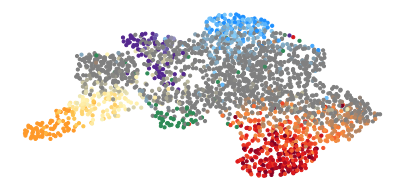

In [46]:
### plot UMAP (just spliced counts)
fig, ax = plt.subplots(1, 1, figsize=(6, 3), frameon=False)
ax.scatter(UMAP_data[:,0], UMAP_data[:,1], s=10, c=cell_colors)
fig.tight_layout()
ax.axis("off")
plt.show()

**Get future states for each cell**

In [47]:
### select MNNs
pos = UMAP_data[mnn]
pos[np.array(mnn)==-1]=np.nan
pos = np.nanmean(pos, axis=1)

<ipython-input-47-c1b3a932b3b1>:4: RuntimeWarning: Mean of empty slice
  pos = np.nanmean(pos, axis=1)


In [48]:
### smoothing; averaging position over nearest neighbours
NN = cKDTree(adata.layers['spliced']).query(x=adata.layers['spliced'], k=30)[1]
pos_mean = np.nanmean(np.array(pos)[NN], axis=1)

<ipython-input-48-a1570a261586>:3: RuntimeWarning: Mean of empty slice
  pos_mean = np.nanmean(np.array(pos)[NN], axis=1)


**Plot future states in UMAP**

In [49]:
### get points for UMAP
v = np.array(pos) - UMAP_data
v_mean = pos_mean - UMAP_data

In [50]:
kwargs = {"scale": 5, "angles": "xy", "scale_units": "xy", "edgecolors": "k", 
          "linewidth": 0.5, "headwidth": 5, "headaxislength": 4}

In [51]:
### plot arrows not for all cells (for less crowded)
sub=np.ones(adata.shape[0])  
sub[np.arange(0, adata.shape[0], 2)]=0
sub = sub.astype(bool)

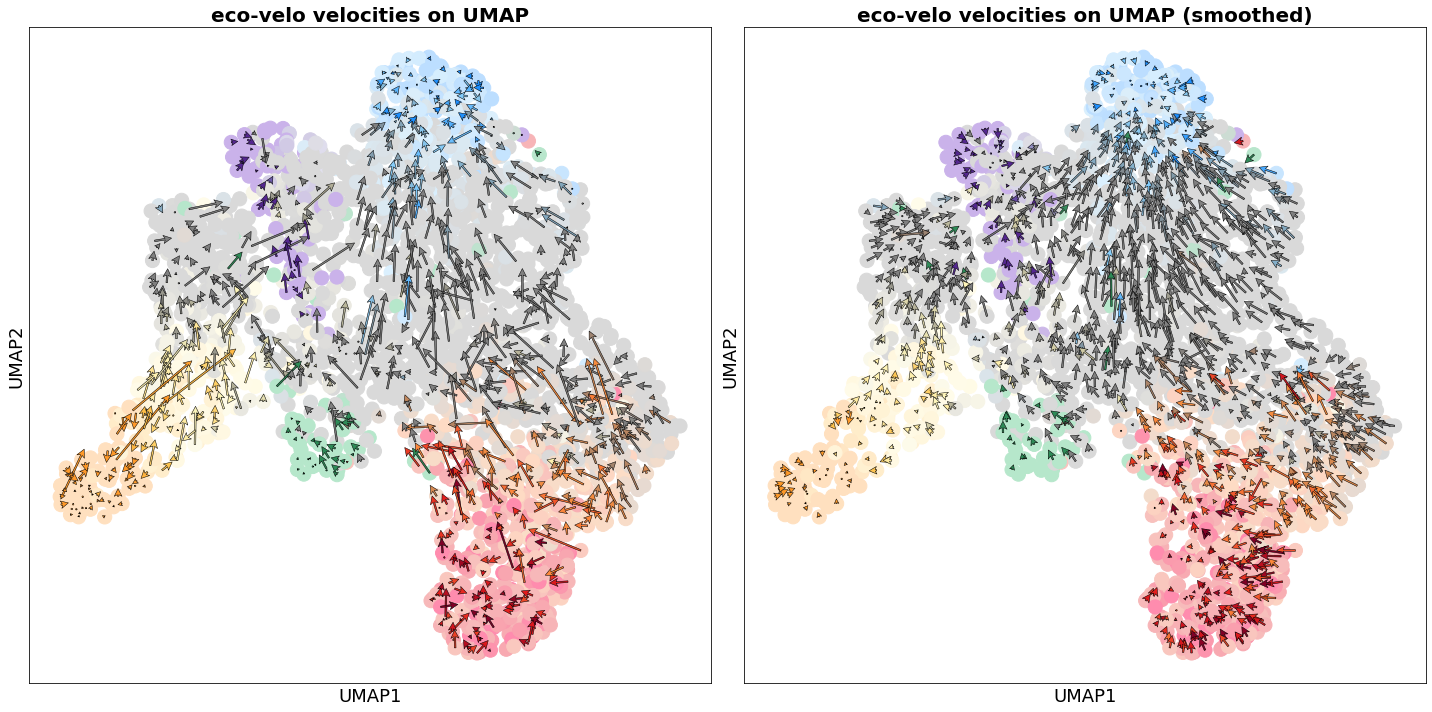

In [53]:
### create PCA plot of pancreas by kappa-velo
fig, axs = plt.subplots(1, 2, figsize=(20, 10))

# plot points (cells) and arrows (velocities)
axs[0].scatter(UMAP_data[:,0], UMAP_data[:,1], color=light_color, s=200)
axs[1].scatter(UMAP_data[:,0], UMAP_data[:,1], color=light_color, s=200)

# make pretty
axs[0].set_xticks([])
axs[0].set_yticks([])
axs[0].set_facecolor('white')
axs[1].set_xticks([])
axs[1].set_yticks([])
axs[1].set_facecolor('white')
fig.patch.set_alpha(0)

# axis labels
axs[0].set_xlabel("UMAP1", fontsize=18)
axs[0].set_ylabel("UMAP2", fontsize=18)
axs[1].set_xlabel("UMAP1", fontsize=18)
axs[1].set_ylabel("UMAP2", fontsize=18)

# title
axs[0].set_title("eco-velo velocities on UMAP", fontsize=20, fontweight="bold")
axs[1].set_title("eco-velo velocities on UMAP (smoothed)", fontsize=20, fontweight="bold")


# plot arrows 
axs[0].quiver(UMAP_data[:,0], UMAP_data[:,1], v[:,0], v[:,1], color=cell_colors, **kwargs)
axs[1].quiver(UMAP_data[sub,0], UMAP_data[sub,1], v_mean[sub,0], v_mean[sub,1], color=cell_colors[sub], **kwargs)

# save plot
plt.tight_layout()
save_path = "../figures/HSPC/HSPC_eco-velo_UMAP.pdf"
plt.savefig(save_path, dpi=300, transparent=True)

plt.show()